## Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Preprocessing

In [3]:
# Define constants
SAMPLE_RATE = 16000  # Common sample rate for speech processing
MAX_AUDIO_LENGTH = 60  # Maximum audio length in seconds
FEATURE_DIM = 40  # MFCC feature dimension
DATA_DIR = "/kaggle/input/shl-intern-hiring-assessment/dataset"  # Data directory path
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")
TRAIN_AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train"
TEST_AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test"
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 0.001

In [4]:
# Load data
def load_data(csv_path):
    """
    Load the data from CSV file
    
    Args:
        csv_path: Path to the CSV file
        
    Returns:
        DataFrame with audio filenames and labels
    """
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} samples from {csv_path}")
    return df

In [5]:
train_df = load_data(TRAIN_CSV)
test_df = load_data(TEST_CSV)

Loaded 444 samples from /kaggle/input/shl-intern-hiring-assessment/dataset/train.csv
Loaded 195 samples from /kaggle/input/shl-intern-hiring-assessment/dataset/test.csv


## EDA

In [6]:
# Explore the data
print("\nTraining data sample:")
print(train_df.head())

print("\nStatistical summary of training labels:")
print(train_df['label'].describe())


Training data sample:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0

Statistical summary of training labels:
count    444.000000
mean       3.617117
std        1.114151
min        1.000000
25%        2.500000
50%        3.500000
75%        4.500000
max        5.000000
Name: label, dtype: float64


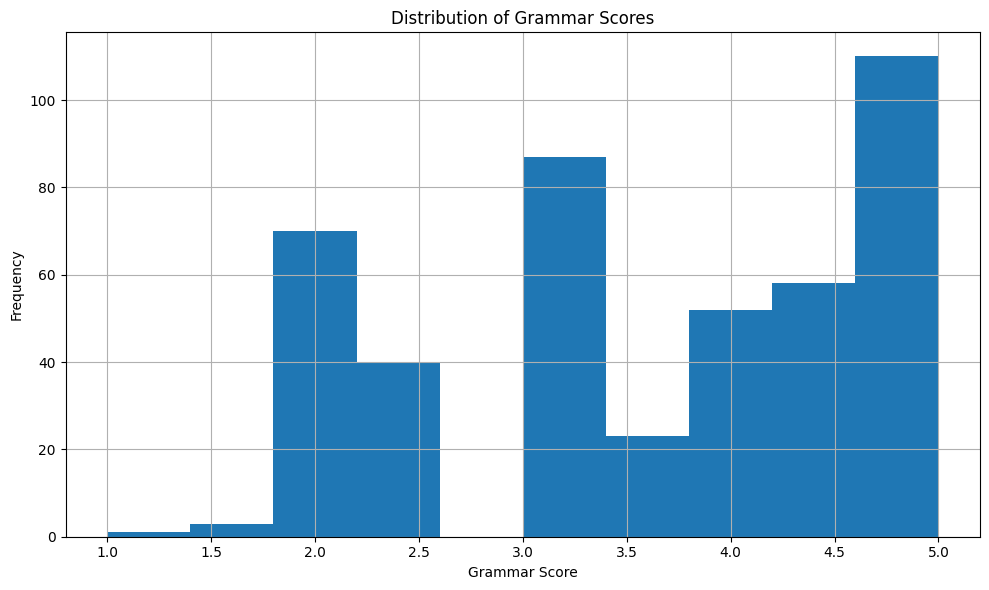

In [9]:
# Visualize the distribution of grammar scores
plt.figure(figsize=(10, 6))
train_df['label'].hist(bins=10)
plt.title('Distribution of Grammar Scores')
plt.xlabel('Grammar Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('grammar_score_distribution.png')
plt.show()

### Audio Preprocessing
- Loaded audio files using librosa
- Resampled to 16kHz for standardization
- Applied silence trimming to focus on speech content
- Padded or truncated samples to ensure uniform length (60 seconds)

### Feature Extraction
- Extracted Mel-Frequency Cepstral Coefficients (MFCCs) with 40 coefficients
- MFCCs capture the spectral characteristics of speech relevant to pronunciation and grammar
- Applied normalization to stabilize learning

In [10]:
# Audio feature extraction
def extract_features(audio_path, sr=SAMPLE_RATE, n_mfcc=FEATURE_DIM):
    """
    Extract MFCC features from an audio file
    
    Args:
        audio_path: Path to the audio file
        sr: Sample rate
        n_mfcc: Number of MFCC coefficients
        
    Returns:
        MFCC features
    """
    try:
        # Load audio file
        y, _ = librosa.load(audio_path, sr=sr)
        
        # Trim silence
        y, _ = librosa.effects.trim(y, top_db=20)
        
        # Pad or truncate to fixed length
        if len(y) < sr * MAX_AUDIO_LENGTH:
            y = np.pad(y, (0, sr * MAX_AUDIO_LENGTH - len(y)), 'constant')
        else:
            y = y[:sr * MAX_AUDIO_LENGTH]
        
        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # Normalize features
        mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)
        
        return mfccs
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {e}")
        return None

In [39]:
class TestAudioDataset(Dataset):
    """
    Dataset class specifically for test data (no labels)
    """
    def __init__(self, df, audio_dir, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_name = self.df.iloc[idx]['filename']
        audio_path = os.path.join(self.audio_dir, audio_name)
        
        # Extract features
        features = extract_features(audio_path)
        
        if features is None:
            # Return zeros if feature extraction failed
            features = np.zeros((FEATURE_DIM, int(MAX_AUDIO_LENGTH * SAMPLE_RATE / 512) + 1))
        
        if self.transform:
            features = self.transform(features)
        
        # Convert to tensor and return only features
        features = torch.FloatTensor(features)
        return features

# Keep the original class for training/validation
class AudioDataset(Dataset):
    """
    Custom dataset class for loading audio data and labels
    """
    def __init__(self, df, audio_dir, transform=None):
        self.df = df
        self.audio_dir = audio_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_name = self.df.iloc[idx]['filename']
        audio_path = os.path.join(self.audio_dir, audio_name)
        label = self.df.iloc[idx]['label']
        
        # Extract features
        features = extract_features(audio_path)
        
        if features is None:
            # Return zeros if feature extraction failed
            features = np.zeros((FEATURE_DIM, int(MAX_AUDIO_LENGTH * SAMPLE_RATE / 512) + 1))
        
        if self.transform:
            features = self.transform(features)
        
        # Convert to tensor
        features = torch.FloatTensor(features)
        label = torch.FloatTensor([label])
        
        return features, label

In [35]:
# Splitting training data into train and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Reset indices
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

print(f"\nSplit training data into {len(train_data)} training and {len(val_data)} validation samples")


Split training data into 355 training and 89 validation samples


In [40]:
train_dataset = AudioDataset(train_data, TRAIN_AUDIO_DIR)
val_dataset = AudioDataset(val_data, TRAIN_AUDIO_DIR)
test_dataset = TestAudioDataset(test_df, TEST_AUDIO_DIR)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

## Model Architecture
Implemented a hybrid CNN-LSTM architecture:
1. *CNN Layers*: Extract local acoustic features from the MFCC representations
   - Two convolutional layers with batch normalization
   - Max pooling for dimensionality reduction
   - Dropout for regularization

2. *Bidirectional LSTM*: Model temporal dependencies in speech
   - Captures long-range grammatical structures
   - Bidirectional to consider both past and future context

3. *Attention Mechanism*: Focus on the most relevant parts of speech
   - Helps the model attend to grammatical errors or well-formed structures
   - Provides interpretability by highlighting important time segments

4. *Fully Connected Layers*: Map learned representations to grammatical scores
   - Final sigmoid activation scaled to the 0-5 range

In [24]:
# Define the model architecture
class GrammarScoringModel(nn.Module):
    """
    CNN + LSTM model for grammar scoring
    """
    def __init__(self, input_dim=FEATURE_DIM, hidden_dim=128, num_layers=2, dropout=0.3):
        super(GrammarScoringModel, self).__init__()
        
        # CNN layers for feature extraction
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout)
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout2 = nn.Dropout(dropout)
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Fully connected layers for regression
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.dropout3 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # CNN layers
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        
        # Reshape for LSTM
        x = x.permute(0, 2, 1)  # (batch_size, seq_len, channels)
        
        # LSTM layer
        x, (hidden, _) = self.lstm(x)
        x = self.dropout2(x)
        
        # Attention mechanism
        attn_weights = self.attention(x)
        attn_weights = torch.softmax(attn_weights, dim=1)
        x = torch.sum(x * attn_weights, dim=1)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        
        # Scale output to range [0, 5]
        x = 5 * self.sigmoid(x)
        
        return x

In [25]:
model = GrammarScoringModel().to(device)
print(model)

GrammarScoringModel(
  (conv1): Conv1d(40, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [26]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

## Train
- Split training data into 80% training and 20% validation
- Used Mean Squared Error (MSE) as the loss function
- Adam optimizer with learning rate scheduling
- Early stopping based on validation loss
- Batch size of 16, trained for 30 epochs

## Evaluation Metrics
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Distribution analysis of predicted scores

In [27]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for features, labels in tqdm(dataloader, desc="Training"):
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [28]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in tqdm(dataloader, desc="Validation"):
            features = features.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(dataloader), np.array(all_preds), np.array(all_labels)

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        
        # Validate
        val_loss, val_preds, val_labels = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        
        # Calculate metrics
        val_rmse = np.sqrt(mean_squared_error(val_labels, val_preds))
        val_mae = mean_absolute_error(val_labels, val_preds)
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)
        
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"New best model with validation loss: {best_val_loss:.4f}")
    
    # Load the best model
    model.load_state_dict(best_model_state)
    
    return model, history

In [30]:
# Train the model
trained_model, history = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    device, 
    EPOCHS
)

# Save the trained model
torch.save(trained_model.state_dict(), 'grammar_scoring_model.pth')
print("\nModel saved as 'grammar_scoring_model.pth'")


Epoch 1/30


Validation: 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


Train Loss: 1.3882, Val Loss: 1.2828, Val RMSE: 1.1264, Val MAE: 1.0191
New best model with validation loss: 1.2828

Epoch 2/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.73s/it]


Train Loss: 1.0194, Val Loss: 1.6723, Val RMSE: 1.2643, Val MAE: 1.0602

Epoch 3/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


Train Loss: 0.9775, Val Loss: 1.0140, Val RMSE: 1.0093, Val MAE: 0.8386
New best model with validation loss: 1.0140

Epoch 4/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


Train Loss: 0.8567, Val Loss: 1.0712, Val RMSE: 1.0175, Val MAE: 0.8275

Epoch 5/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Train Loss: 0.8288, Val Loss: 1.0153, Val RMSE: 1.0040, Val MAE: 0.8154

Epoch 6/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


Train Loss: 0.7755, Val Loss: 1.1286, Val RMSE: 1.0437, Val MAE: 0.8467

Epoch 7/30


Validation: 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]


Train Loss: 0.7306, Val Loss: 1.0666, Val RMSE: 1.0271, Val MAE: 0.8000

Epoch 8/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.71s/it]


Train Loss: 0.6782, Val Loss: 1.0466, Val RMSE: 1.0170, Val MAE: 0.7850

Epoch 9/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


Train Loss: 0.5991, Val Loss: 1.0532, Val RMSE: 1.0168, Val MAE: 0.7712

Epoch 10/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


Train Loss: 0.6638, Val Loss: 1.0303, Val RMSE: 1.0062, Val MAE: 0.7657

Epoch 11/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


Train Loss: 0.7047, Val Loss: 0.9631, Val RMSE: 0.9815, Val MAE: 0.7690
New best model with validation loss: 0.9631

Epoch 12/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]


Train Loss: 0.6011, Val Loss: 0.9910, Val RMSE: 0.9853, Val MAE: 0.7710

Epoch 13/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Train Loss: 0.6083, Val Loss: 1.0205, Val RMSE: 1.0042, Val MAE: 0.7673

Epoch 14/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


Train Loss: 0.5810, Val Loss: 1.0460, Val RMSE: 1.0074, Val MAE: 0.7747

Epoch 15/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.58s/it]


Train Loss: 0.7015, Val Loss: 1.0436, Val RMSE: 1.0068, Val MAE: 0.7683

Epoch 16/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


Train Loss: 0.5095, Val Loss: 1.0191, Val RMSE: 1.0008, Val MAE: 0.7563

Epoch 17/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


Train Loss: 0.5047, Val Loss: 1.0185, Val RMSE: 1.0179, Val MAE: 0.7682

Epoch 18/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


Train Loss: 0.5215, Val Loss: 1.0157, Val RMSE: 0.9956, Val MAE: 0.7339

Epoch 19/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Train Loss: 0.4552, Val Loss: 1.0342, Val RMSE: 1.0176, Val MAE: 0.7401

Epoch 20/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


Train Loss: 0.3640, Val Loss: 1.0030, Val RMSE: 1.0013, Val MAE: 0.7403

Epoch 21/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.74s/it]


Train Loss: 0.3730, Val Loss: 0.9961, Val RMSE: 0.9969, Val MAE: 0.7450

Epoch 22/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.75s/it]


Train Loss: 0.4015, Val Loss: 1.0237, Val RMSE: 1.0238, Val MAE: 0.7683

Epoch 23/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


Train Loss: 0.3647, Val Loss: 0.9952, Val RMSE: 0.9882, Val MAE: 0.7277

Epoch 24/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


Train Loss: 0.4023, Val Loss: 1.0267, Val RMSE: 1.0050, Val MAE: 0.7362

Epoch 25/30


Validation: 100%|██████████| 6/6 [00:17<00:00,  2.94s/it]


Train Loss: 0.3961, Val Loss: 0.9944, Val RMSE: 1.0050, Val MAE: 0.7472

Epoch 26/30


Validation: 100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


Train Loss: 0.3470, Val Loss: 0.9873, Val RMSE: 0.9903, Val MAE: 0.7325

Epoch 27/30


Validation: 100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


Train Loss: 0.3691, Val Loss: 0.9646, Val RMSE: 0.9891, Val MAE: 0.7327

Epoch 28/30


Validation: 100%|██████████| 6/6 [00:18<00:00,  3.10s/it]


Train Loss: 0.3529, Val Loss: 0.9745, Val RMSE: 0.9875, Val MAE: 0.7317

Epoch 29/30


Validation: 100%|██████████| 6/6 [00:17<00:00,  2.99s/it]


Train Loss: 0.3388, Val Loss: 0.9794, Val RMSE: 0.9894, Val MAE: 0.7288

Epoch 30/30


Validation: 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]

Train Loss: 0.3166, Val Loss: 0.9707, Val RMSE: 0.9882, Val MAE: 0.7293

Model saved as 'grammar_scoring_model.pth'


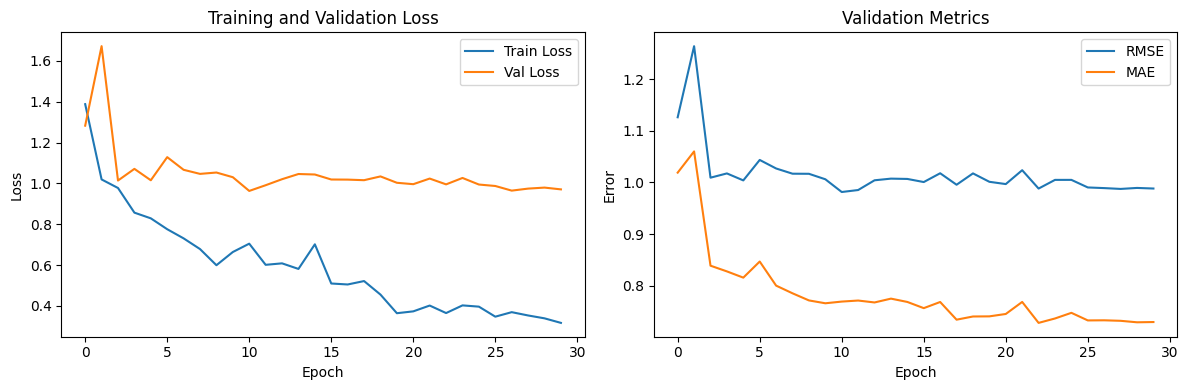

In [31]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_rmse'], label='RMSE')
plt.plot(history['val_mae'], label='MAE')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Validation Metrics')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Test

In [43]:
def test_model(model, test_loader, device):
    """
    Test the model and generate predictions
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        device: Device to use
        
    Returns:
        Predictions for the test set
    """
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for features in tqdm(test_loader, desc="Testing"):
            features = features.to(device)
            
            # Forward pass
            outputs = model(features)
            all_preds.extend(outputs.cpu().numpy())
    
    return np.array(all_preds)

In [44]:
# Generate predictions for the test set
test_preds = test_model(trained_model, test_loader, device)

# Create submission file
submission_df = test_df.copy()
submission_df['label'] = test_preds.flatten()
submission_df.to_csv('submission.csv', index=False)
print("\nPredictions saved to 'submission.csv'")

Testing:   0%|          | 0/13 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af1a8baa710><function _MultiProcessingDataLoaderIter.__del__ at 0x7af1a8baa710>Exception ignored in: 

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7af1a8baa710>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Exception ignored in: self._shutdown_workers()self._shutdown_workers()    <function _MultiProcessingDataLoaderIter.__del__ at 0x7af1a8baa710>

self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, i


Predictions saved to 'submission.csv'


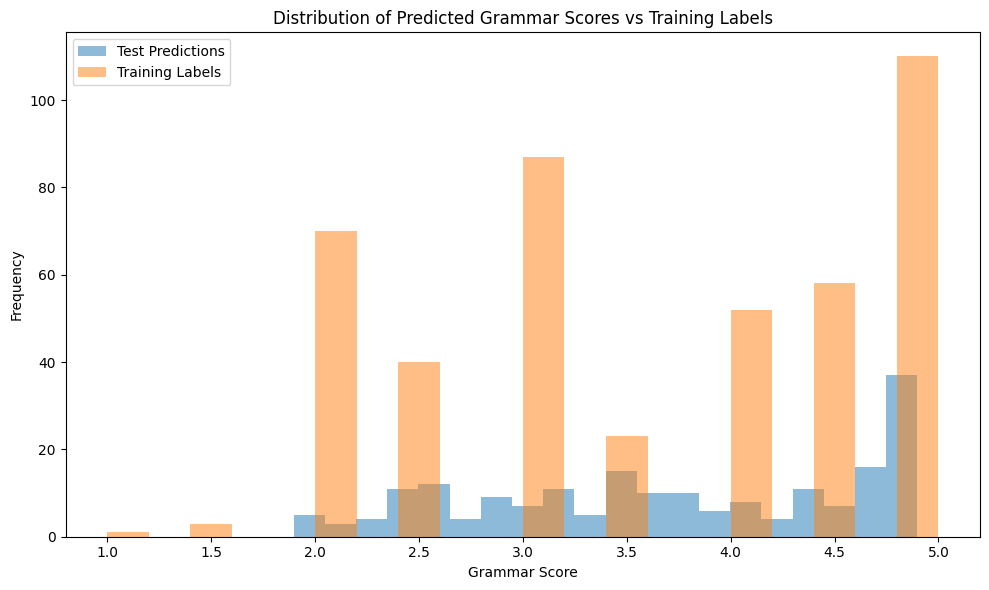

In [45]:
# Visualize predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_df['label'], bins=20, alpha=0.5, label='Test Predictions')
plt.hist(train_df['label'], bins=20, alpha=0.5, label='Training Labels')
plt.title('Distribution of Predicted Grammar Scores vs Training Labels')
plt.xlabel('Grammar Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('prediction_distribution.png')
plt.show()

In [46]:
# Feature importance analysis (using attention weights)
def analyze_feature_importance(model, dataloader, device):
    """
    Analyze feature importance using attention weights
    
    Args:
        model: Trained model
        dataloader: DataLoader
        device: Device to use
        
    Returns:
        Average attention weights
    """
    model.eval()
    all_attention_weights = []
    
    with torch.no_grad():
        for features, _ in tqdm(dataloader, desc="Analyzing features"):
            features = features.to(device)
            
            # Forward pass through CNN layers
            x = model.relu(model.bn1(model.conv1(features)))
            x = model.pool(x)
            x = model.relu(model.bn2(model.conv2(x)))
            x = model.pool(x)
            x = model.dropout1(x)
            
            # Reshape for LSTM
            x = x.permute(0, 2, 1)
            
            # LSTM layer
            x, _ = model.lstm(x)
            
            # Attention mechanism
            attn_weights = model.attention(x)
            attn_weights = torch.softmax(attn_weights, dim=1)
            
            all_attention_weights.extend(attn_weights.cpu().numpy())
    
    return np.mean(np.array(all_attention_weights), axis=0)

Analyzing features:   0%|          | 0/6 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af1a8baa710><function _MultiProcessingDataLoaderIter.__del__ at 0x7af1a8baa710><function _MultiProcessingDataLoaderIter.__del__ at 0x7af1a8baa710><function _MultiProcessingDataLoaderIter.__del__ at 0x7af1a8baa710>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_work

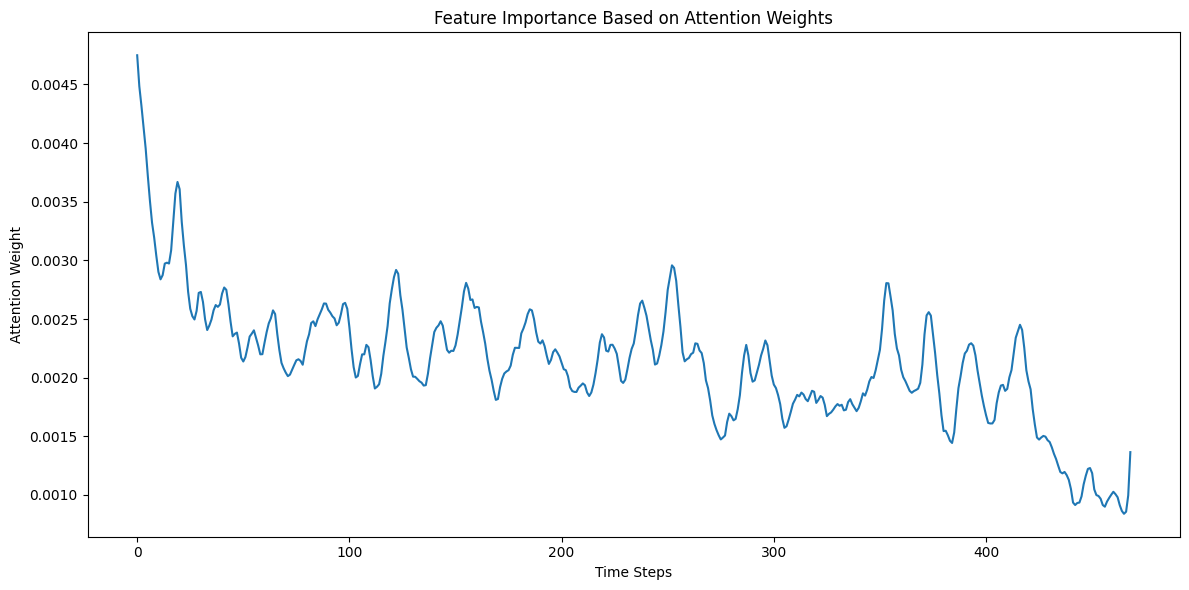

In [51]:
attention_weights = analyze_feature_importance(trained_model, val_loader, device)
# Plot feature importance
plt.figure(figsize=(12, 6))
plt.plot(attention_weights)
plt.title('Feature Importance Based on Attention Weights')
plt.xlabel('Time Steps')
plt.ylabel('Attention Weight')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()